Here I'll mostly work with the new file formats from Amirsadra and build on them

In [1]:
import copy
import re
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib as mpl
from matplotlib import pyplot as plt; # plt.style.use('dark_background')
import matplotlib.patches as patches
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.patches import Wedge

In [2]:
# Here we deal with reading infomation from files

STATES_SEQUENCE_FILE = 'Epochs_OSBasic_Rat3_AllSDs_NoArtifact&TS_timeOrder.txt'  # example for file (living in the data folder)

def get_df_from_states_file(file_name, folder_path='data'):  # this assumes files are saved on the data/ path for now
    latent_states_sequence = []
    with open(f'{folder_path}/{file_name}', 'r') as file:
        lines = file.readlines()
        data_lines = [line for line in lines if not line.startswith('---') and not line.startswith('ID')]
        parsed_data = [re.split(r'\s{2,}|\t+', line.strip()) for line in data_lines if line.strip]
        df = pd.DataFrame(parsed_data, columns=['id', 'binary_pattern', 'train_state', 'sleep_stage'])
        df['train_state'] = df['train_state'].astype(int)
        df.drop(columns=['id'], inplace=True)
    return df

df = get_df_from_states_file(STATES_SEQUENCE_FILE)
df.head()

,binary_pattern,train_state,sleep_stage
0,1101111001,74,Wake
1,1101101001,66,Wake
2,1111101001,90,Wake
3,1111101000,89,Wake
4,1111101000,89,Wake


In [3]:
# Here we extract info from the df

def get_states_sequence_from_df(df, column='train_state'):
    assert column in df.columns, f'Unrecognised column name. The available columns are {list(df.columns)}'
    latent_states_sequence = df[column].tolist()
    return latent_states_sequence

def get_state_sleep_stage_relationship(df, state_col='train_state'):
    """Get a sleep stage frequency dictionary for each train state"""
    grouped = df.groupby(state_col)['sleep_stage'].value_counts()
    return grouped.unstack(fill_value=0).to_dict(orient='index')

def get_manual_sleep_stage_mapping(df, state_col='train_state'):
    """Return a dictionary with the latent states as keys and the sleep stages assigned to them most often as values."""
    nested_dict = get_state_sleep_stage_relationship(df, state_col=state_col)
    return {state: max(stages, key=stages.get) for state, stages in nested_dict.items()}

def get_activation_pattern_train_state_mapping(df, key='train_state', val='binary_pattern'):
    mapping = dict(zip(df[key], df[val]))
    val_from_mapping = df[key].map(mapping)
    assert val_from_mapping.equals(df[val]), 'There is something wrong with the df mapping between the 2 columns'
    return mapping

latent_states_sequence = get_states_sequence_from_df(df)
sleep_stage_mapping_frequency = get_state_sleep_stage_relationship(df)
manually_labelled_dict = get_manual_sleep_stage_mapping(df)
state_to_pattern_dict = get_activation_pattern_train_state_mapping(df)

In [4]:
# Functions to get the raw data in a useful format (simplified states sequence, transition dict etc.)

def simplify_states_sequence(latent_states_sequence):
    """Take a raw states sequence (as in the rat files) and simplify it by counting how often the same state appears in a subsequence.
    The result will be a list where each element is a tuple with the first entry being a state and the second being a count.
    e.g., the sequence 22 → 71 → 71 → 71 → 15 → 15 → 2 becomes (22, 1) → (71, 3) → (15, 2) → (2, 1)"""
    prev_state = latent_states_sequence[0]
    duration = 1
    simplified_states_sequence = []
    for next_state in latent_states_sequence[1:]:
        if next_state == prev_state:
            duration += 1
        else:
            simplified_states_sequence.append((prev_state, duration))
            prev_state = next_state
            duration = 1
    simplified_states_sequence.append((prev_state, duration))
    assert sum(x[1] for x in simplified_states_sequence) == len(latent_states_sequence), 'States count in the simplified sequence is incorrect'
    return simplified_states_sequence


def build_transition_dict(simplified_states_sequence, include_self_loops=False):
    """Take a simplified states sequence and build a dictionary for the state (and associated frequency) transitions.
    This dictionary will contain no cycles by default (as we are working on the simplified sequence).
    The count corresponds to how often a state transitions into another."""
    transition_dict = {}
    for idx in range(len(simplified_states_sequence) - 1):
        cur_state, next_state = simplified_states_sequence[idx][0], simplified_states_sequence[idx + 1][0]
        if cur_state in transition_dict:
            transition_dict[cur_state][next_state] = transition_dict[cur_state].get(next_state, 0) + 1
        else:
            transition_dict[cur_state] = {next_state: 1}

    if include_self_loops:  # then we also add how often self transitions happen (inferred from the state duration)
        for state, duration in simplified_states_sequence:
            if duration > 1:  # then there is at least 1 self-transition
                if state in transition_dict:
                    transition_dict[state][state] = transition_dict[state].get(state, 0) + duration - 1
                else:
                    transition_dict[state] = {state: duration - 1}
    return transition_dict


def build_transition_graph(transition_dict, use_raw_edge_weights=False):
    G = nx.DiGraph()
    for src, targets in transition_dict.items():
        out_degree = 1 if use_raw_edge_weights else sum(targets.values())
        for dst, weight in targets.items():
            G.add_edge(src, dst, weight=weight / out_degree)
    return G

simplified_states_sequence = simplify_states_sequence(latent_states_sequence)
sleep_stages = simplify_states_sequence(get_states_sequence_from_df(df, 'sleep_stage'))
transition_dict = build_transition_dict(simplified_states_sequence)
transition_graph = build_transition_graph(transition_dict)

In [5]:
# These are a bunch of utility functions

def get_state_frequency(simplified_states_sequence, transform_to_ratios=False):
    """Return a dictionary with the frequency of each state"""
    state_frequency = {}
    for (state, duration) in simplified_states_sequence:
        state_frequency[state] = state_frequency.get(state, 0) + duration
    assert sum(x[1] for x in simplified_states_sequence) == sum(state_frequency.values())
    if transform_to_ratios:
        state_frequency = {state: round(duration / sum(state_frequency.values()), 3) for state, duration in state_frequency.items()}
    return state_frequency

def get_states_list_ordered_by_freq(simplified_states_sequence, reverse=True):
    state_frequency = get_state_frequency(simplified_states_sequence)
    states_ordered_by_freq = sorted([(key, val) for key, val in state_frequency.items()], key=lambda x: x[1], reverse=reverse)
    return [x[0] for x in states_ordered_by_freq]

def build_community_sequence_from_simplified_sequence(simplified_states_sequence, node_mapping):
    result = []
    prev = None
    current_duration = 0
    for state, duration in simplified_states_sequence:
        mapped = node_mapping[state]
        if mapped != prev:
            if prev is not None:
                result.append((prev, current_duration))
            current_duration = duration
            prev = mapped
        else:
            current_duration += duration
    result.append((prev, current_duration))
    return result

def resimplify_simplified_states_sequence(simplified_states_sequence):
    """Resimplify a states sequence where consecutive entries might be on the same node (following a relabelling)
    e.g., (7, 2), (7, 3) becomes (7, 5)"""
    result = []
    prev = None
    current_duration = 0
    for state, duration in simplified_states_sequence:
        if state != prev:
            if prev is not None:
                result.append((prev, current_duration))
            current_duration = duration
            prev = state
        else:
            current_duration += duration
    result.append((prev, current_duration))
    assert sum(x[1] for x in result) == sum(x[1] for x in simplified_states_sequence)
    return result

def compute_distance_between_states(state1, state2, state_to_pattern_dict):
    """Compute the Hamming distance between the activation patterns corresponding to 2 states"""
    print(state_to_pattern_dict[state1])
    print(state_to_pattern_dict[state2])
    return sum(a != b for a, b in zip(state_to_pattern_dict[state1], state_to_pattern_dict[state2]))

In [6]:
# Here we mostly deal with infomap and similar stuff

from infomap import Infomap  # this package was a pain to install due to C++ dependencies. I do not wish it on my worst enemy

def apply_infomap(simplified_states_sequence, use_raw_edge_weights=True, include_self_loops=False):
    """Build a dictionary with the communities produced my infomap
    This is the trivial application of infomap and more complicated ones may be used in the future."""
    #todo make this function more concise
    im = Infomap("--directed --two-level")
    transition_dict = build_transition_dict(simplified_states_sequence, include_self_loops=include_self_loops)
    for source, targets in transition_dict.items():
        total_flow = 1 if use_raw_edge_weights else sum(targets.values())
        for target, weight in targets.items():
            im.add_link(source, target, weight / total_flow)
    im.run()
    print(f'The associated infomap code length is {round(im.codelength, 2)}')

    node_community_mapping = {}
    for node in im.tree:
        if node.is_leaf:
            module = node.module_id
            node_id = node.node_id
            node_community_mapping[node_id] = module  
    return node_community_mapping

def get_infomap_communities_from_mapping(node_community_mapping, print_result=False):
    communities_dict = {}
    for node, com in node_community_mapping.items():
        communities_dict.setdefault(com, []).append(node)
    for com in communities_dict:
        communities_dict[com].sort()
    if print_result:
        foo = [(com, nodes) for com, nodes in communities_dict.items()]
        foo.sort(key=lambda x: x[0])
        for com, nodes in foo:
            print(f'{com}: {nodes}')
    return communities_dict

node_community_mapping = apply_infomap(simplified_states_sequence, use_raw_edge_weights=True)

The associated infomap code length is 4.44


In [ ]:
# #TODO Here are some experiments with multi-level infomap (to add more to this one in due course)

# im = Infomap("--directed")

# for source, targets in transition_dict.items():
#     for target, weight in targets.items():
#         im.add_link(source, target, weight)

# # for source, targets in transition_dict.items():
# #     total_flow = sum(targets.values())
# #     for target, weight in targets.items():
# #         im.add_link(source, target, weight/total_flow)

# im.run()

# for node in im.tree:
#     if node.is_leaf:
#         # print(node.node_id)
#         print(node.path)
#         # print(node.module_id)
#         # print(node.path[0] == node.module_id)

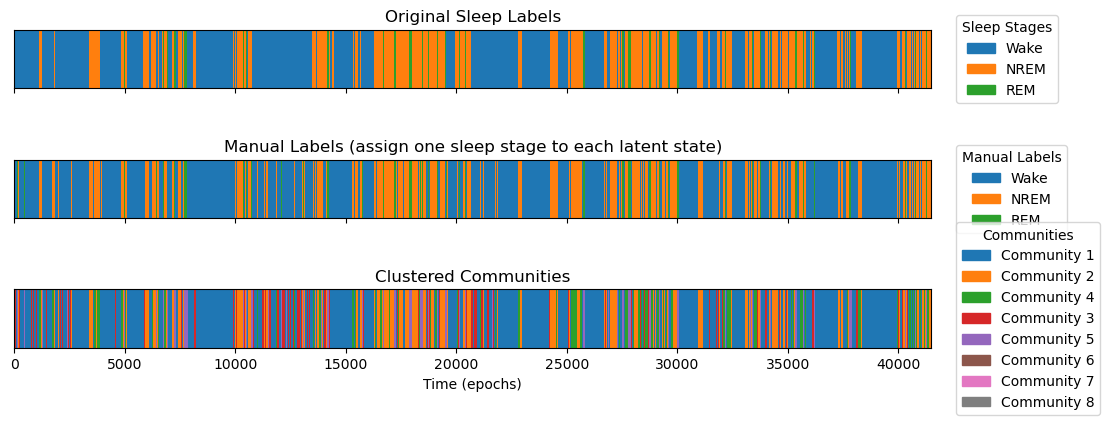

In [7]:
# Here we plot sleep slabs

def assign_colours_to_communities(communities: list):
    """Return a dictionary with community numbers as keys and colours as values"""
    assert len(communities) <= 20, f'At most 20 colours are accepted'

    # This is a hacky way to make sure Wake, NREM, REM always appear in this order 
    target_values = ['Wake', 'NREM', 'REM']
    communities = [x for x in target_values if x in communities] + [x for x in communities if x not in target_values]
    
    if len(communities) <= 10:
        colours = plt.colormaps['tab10']  # tab10_r
    else:
        colours = plt.colormaps['tab20']
    return {com:colours(idx) for idx, com in enumerate(communities)}


def draw_simplified_sleep_slab(simplified_states_sequence, xlim=None, custom_title=None):
    total_time = sum(duration for _, duration in simplified_states_sequence)
    fig, ax = plt.subplots(figsize=(12, 2))
    ax.set_xlim(0, total_time)
    ax.set_yticks([])

    states = get_states_list_ordered_by_freq(simplified_states_sequence)
    colour_map = assign_colours_to_communities(states)

    start = 0
    for state, duration in simplified_states_sequence:
        rect = patches.Rectangle((start, 0), duration, 1, facecolor=colour_map[state])
        ax.add_patch(rect)
        start += duration

    handles = [patches.Patch(color=colour_map[state], label=state) for state in states]
    ax.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xlabel("Time (epochs)")
    if custom_title is not None:
        plt.title(custom_title)
    else:
        plt.title("Sleep Plot")
    plt.tight_layout()
    if xlim is not None:
        plt.xlim(*xlim)
    plt.show()

    
def draw_clustered_sleep(simplified_states_sequence, node_mapping, add_latent_state_breakdown=False, xlim=None):
    # Step 1: Convert state_sequence into community-segmented blocks
    community_sequence = []
    prev_community = None
    current_duration = 0

    for state, duration in simplified_states_sequence:
        community = node_mapping[state]
        if community != prev_community:
            if prev_community is not None:
                community_sequence.append((prev_community, current_duration))
            current_duration = duration
            prev_community = community
        else:
            current_duration += duration
    community_sequence.append((prev_community, current_duration))  # append last

    communities = get_states_list_ordered_by_freq(community_sequence)
    colour_map = assign_colours_to_communities(communities)

    # Step 3: Set up plot
    total_time = sum(duration for _, duration in simplified_states_sequence)
    fig, ax = plt.subplots(figsize=(12, 2))
    ax.set_xlim(0, total_time)
    ax.set_yticks([])

    # Step 4: Plot community blocks
    start = 0
    for community, duration in community_sequence:
        rect = patches.Rectangle((start, 0), duration, 1, facecolor=colour_map[community])
        ax.add_patch(rect)
        start += duration

    # Step 5: Optionally add dotted lines and state labels
    if add_latent_state_breakdown:
        time_cursor = 0
        for state, duration in simplified_states_sequence:
            mid = time_cursor + duration / 2
            ax.text(mid, .47, str(state), ha='center', va='bottom', fontsize=5)
            time_cursor += duration
            if time_cursor < total_time:
                ax.axvline(time_cursor, color='black', linestyle=':', linewidth=0.8)

    # Step 6: Add legend and plot
    handles = [patches.Patch(color=colour_map[c], label=f'Community {c}') for c in communities]
    ax.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xlabel("Time (epochs)")
    plt.title("Clustered Sleep Plot" + (" with Latent State Breakdown" if add_latent_state_breakdown else ""))
    plt.tight_layout()
    if xlim is not None:
        plt.xlim(*xlim)
    plt.show()


def draw_all_sleep_slabs(simplified_states_sequence, sleep_stages, node_community_mapping, manually_labelled_dict=None, xlim=None):
    # Step 1: Build both sequences in one pass
    community_sequence = build_community_sequence_from_simplified_sequence(simplified_states_sequence, node_community_mapping)
    if manually_labelled_dict is not None:
        manual_sequence = build_community_sequence_from_simplified_sequence(simplified_states_sequence, manually_labelled_dict)

    # Step 2: Define colour maps
    communities = get_states_list_ordered_by_freq(community_sequence)
    community_colour_map = assign_colours_to_communities(communities)
    
    labels = get_states_list_ordered_by_freq(sleep_stages)
    label_colour_map = assign_colours_to_communities(labels)

    # Step 3: Set up subplots
    total_time = sum(duration for _, duration in simplified_states_sequence)
    if manually_labelled_dict is None:
        fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(12, 3.2), sharex=True, height_ratios=[1, 1])
    else:
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 4.2), sharex=True, height_ratios=[1, 1, 1])
    fig.subplots_adjust(hspace=0.3)

    # Step 4: Plot the original sleep stages
    start = 0
    for stage, duration in sleep_stages:
        rect = patches.Rectangle((start, 0), duration, 1, facecolor=label_colour_map[stage])
        ax1.add_patch(rect)
        start += duration
    ax1.set_xlim(0, total_time)
    ax1.set_ylim(0, 1)
    ax1.set_yticks([])
    ax1.set_title("Original Sleep Labels")
    sleep_stage_handles = [patches.Patch(color=label_colour_map[s], label=s) for s in labels]
    ax1.legend(handles=sleep_stage_handles, bbox_to_anchor=(1.02, 0.5), loc='center left', title='Sleep Stages')
    
    # Step 5: (Optionally) plot manual labels (once you associate one stage to each train_state)
    if manually_labelled_dict is not None:
        start = 0
        for label, duration in manual_sequence:
            rect = patches.Rectangle((start, 0), duration, 1, facecolor=label_colour_map[label])
            ax2.add_patch(rect)
            start += duration
        ax2.set_xlim(0, total_time)
        ax2.set_ylim(0, 1)
        ax2.set_yticks([])
        ax2.set_title("Manual Labels (assign one sleep stage to each latent state)")
        manual_handles = [patches.Patch(color=label_colour_map[l], label=l) for l in labels]
        ax2.legend(handles=manual_handles, bbox_to_anchor=(1.02, 0.5), loc='center left', title='Manual Labels')

    # Step 6: Plot community labels as resulting from clustering algo
    start = 0
    for community, duration in community_sequence:
        rect = patches.Rectangle((start, 0), duration, 1, facecolor=community_colour_map[community])
        ax3.add_patch(rect)
        start += duration
    ax3.set_xlim(0, total_time)
    ax3.set_ylim(0, 1)
    ax3.set_yticks([])
    ax3.set_title("Clustered Communities")
    community_handles = [patches.Patch(color=community_colour_map[c], label=f'Community {c}') for c in communities]
    ax3.legend(handles=community_handles, bbox_to_anchor=(1.02, 0.5), loc='center left', title='Communities')
    
    ax3.set_xlabel("Time (epochs)")

    # Step 7: Optional xlim
    if xlim is not None:
        ax1.set_xlim(*xlim)
        ax2.set_xlim(*xlim)
        ax3.set_xlim(*xlim)

    # Step 8: Plot
    plt.tight_layout()
    plt.subplots_adjust(right=0.78)  # Shrinks plotting area to leave room
    plt.show()

draw_all_sleep_slabs(simplified_states_sequence=simplified_states_sequence,
                    sleep_stages=sleep_stages,
                    node_community_mapping=node_community_mapping,
                    manually_labelled_dict=manually_labelled_dict,
                    # xlim=(15_000, 20_000)
                    )

In [8]:
# These are functions used for plotting the transition graphs

def get_node_sizes(simplified_states_sequence, min_node_size=150, max_node_size=1500):
    """Return a dictionary for the size of each node in the graph"""
    #todo should this use the state frequency or the node frequency?
    #todo make it work with other types of states/nodes as well
    state_frequency = get_state_frequency(simplified_states_sequence)
    min_freq = min(state_frequency.values())
    max_freq = max(state_frequency.values())
    node_sizes = {node: (max_node_size - min_node_size) * ((freq - min_freq) / (max_freq - min_freq)) + min_node_size for node, freq in state_frequency.items()}
    return node_sizes


def draw_transition_graph(simplified_states_sequence, community_mapping=None, draw_raw_edge_weights=False, edge_weight_font_size=7, node_label_mapping=None, custom_title=None, seed=None):
    transition_dict = build_transition_dict(simplified_states_sequence)
    G = build_transition_graph(transition_dict)
    pos = nx.spring_layout(G, seed=seed)  # 43
    
    plt.figure(figsize=(15, 10))

    node_sizes_dict = get_node_sizes(simplified_states_sequence)
    node_sizes = [node_sizes_dict[node] for node in G.nodes()]
    
    edge_weights = [G[u][v]['weight'] for u, v in G.edges()]

    if community_mapping is None:
        communities = sorted(set(x[0] for x in simplified_states_sequence))
        community_to_colour = assign_colours_to_communities(communities)
        node_colours = [community_to_colour[node] for node in G.nodes()]
    else:
        communities = sorted(set(community_mapping.values()))
        community_to_colour = assign_colours_to_communities(communities)
        node_colours = [community_to_colour[community_mapping[node]] for node in G.nodes()]

    nx.draw_networkx_nodes(G, pos, node_color=node_colours, node_size=node_sizes)

    nx.draw_networkx_edges(
        G, pos,
        edgelist=G.edges(),
        edge_color='gray',
        width=[w * 3 for w in edge_weights],
        arrows=True,
        connectionstyle='arc3,rad=0.1'
    )
    if draw_raw_edge_weights:
        G_raw = build_transition_graph(transition_dict=transition_dict, use_raw_edge_weights=True)
        nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): int(G_raw[u][v]['weight']) for u, v in G.edges()}, font_size=edge_weight_font_size, label_pos=0.2, rotate=False)

    if node_label_mapping:
        labels = {node: node_label_mapping.get(node, node) for node in G.nodes()}
    else:
        labels = {node: node for node in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels=labels)

    legend_handles = [patches.Patch(color=color, label=community) for community, color in community_to_colour.items()]
    plt.legend(handles=legend_handles, title="Communities", loc="upper right")

    if custom_title is not None:
        plt.title(custom_title)
    else:
        plt.title('Transition Graph of Latent States')
    plt.axis('off')
    plt.show()


def draw_community_transition_graph(simplified_states_sequence, community_mapping, seed=None):
    simplified_community_sequence = build_community_sequence_from_simplified_sequence(simplified_states_sequence, community_mapping)
    draw_transition_graph(simplified_community_sequence, draw_raw_edge_weights=True, edge_weight_font_size=12, seed=seed)


def draw_pie_node(ax, center, radius, proportions, colours):
    """Draw a pie chart node at a given center."""
    start_angle = 0
    for frac, colour in zip(proportions, colours):
        if frac == 0:
            continue
        end_angle = start_angle + frac * 360
        wedge = Wedge(center, radius, start_angle, end_angle, facecolor=colour, edgecolor='none', linewidth=0)
        ax.add_patch(wedge)
        start_angle = end_angle


def draw_transition_graph_with_pie_chart_nodes(simplified_states_sequence, sleep_stage_mapping_frequency, draw_raw_edge_weights=False, edge_weight_font_size=7, node_label_mapping=None, custom_title=None, seed=None):
    transition_dict = build_transition_dict(simplified_states_sequence)
    G = build_transition_graph(transition_dict)
    pos = nx.spring_layout(G, seed=seed)  # 43
    
    plt.figure(figsize=(15, 10))
    plt.axis('equal')
    ax = plt.gca()

    node_sizes_dict = get_node_sizes(simplified_states_sequence)
    node_sizes = [node_sizes_dict[node] for node in G.nodes()]
    
    edge_weights = [G[u][v]['weight'] for u, v in G.edges()]

    sleep_stages = list({k for inner in sleep_stage_mapping_frequency.values() for k in inner})
    community_to_colour = assign_colours_to_communities(sleep_stages)

    for node in G.nodes():
        centre = pos[node]
        size = node_sizes_dict[node] ** 0.5 / 800  # adjust node size scale manually  #TODO

        freqs = sleep_stage_mapping_frequency[node]
        total = sum(freqs.values())
        proportions = [v / total for v in freqs.values()]
        labels = list(freqs.keys())
    
        colours = [community_to_colour[label] for label in labels] 
    
        draw_pie_node(ax, centre, radius=size, proportions=proportions, colours=colours)

    nx.draw_networkx_edges(
        G, pos,
        edgelist=G.edges(),
        edge_color='gray',
        width=[w * 3 for w in edge_weights],
        arrows=True,
        connectionstyle='arc3,rad=0.1'
    )
    
    if draw_raw_edge_weights:
        G_raw = build_transition_graph(transition_dict=transition_dict, use_raw_edge_weights=True)
        nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): int(G_raw[u][v]['weight']) for u, v in G.edges()}, font_size=edge_weight_font_size, label_pos=0.2, rotate=False)

    if node_label_mapping:
        labels = {node: node_label_mapping.get(node, node) for node in G.nodes()}
    else:
        labels = {node: node for node in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels=labels)

    legend_handles = [patches.Patch(color=color, label=community) for community, color in community_to_colour.items()]
    plt.legend(handles=legend_handles, title="Communities", loc="upper right")

    if custom_title is not None:
        plt.title(custom_title)
    else:
        plt.title('Transition Graph of Latent States')
    plt.axis('off')
    plt.show()

The associated infomap code length is 4.5


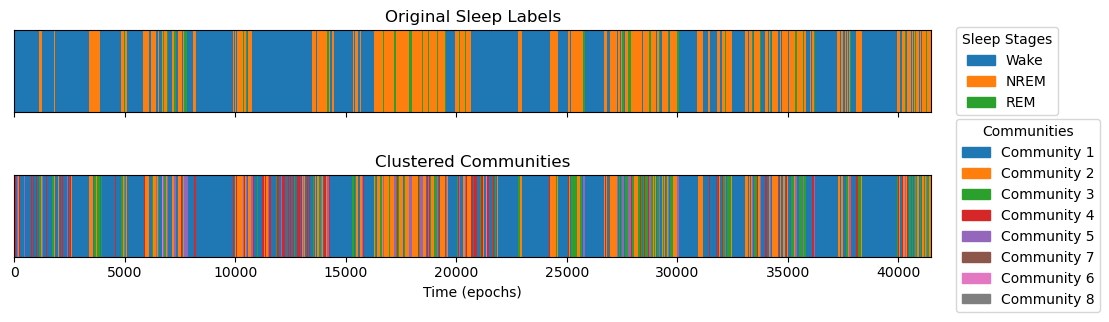

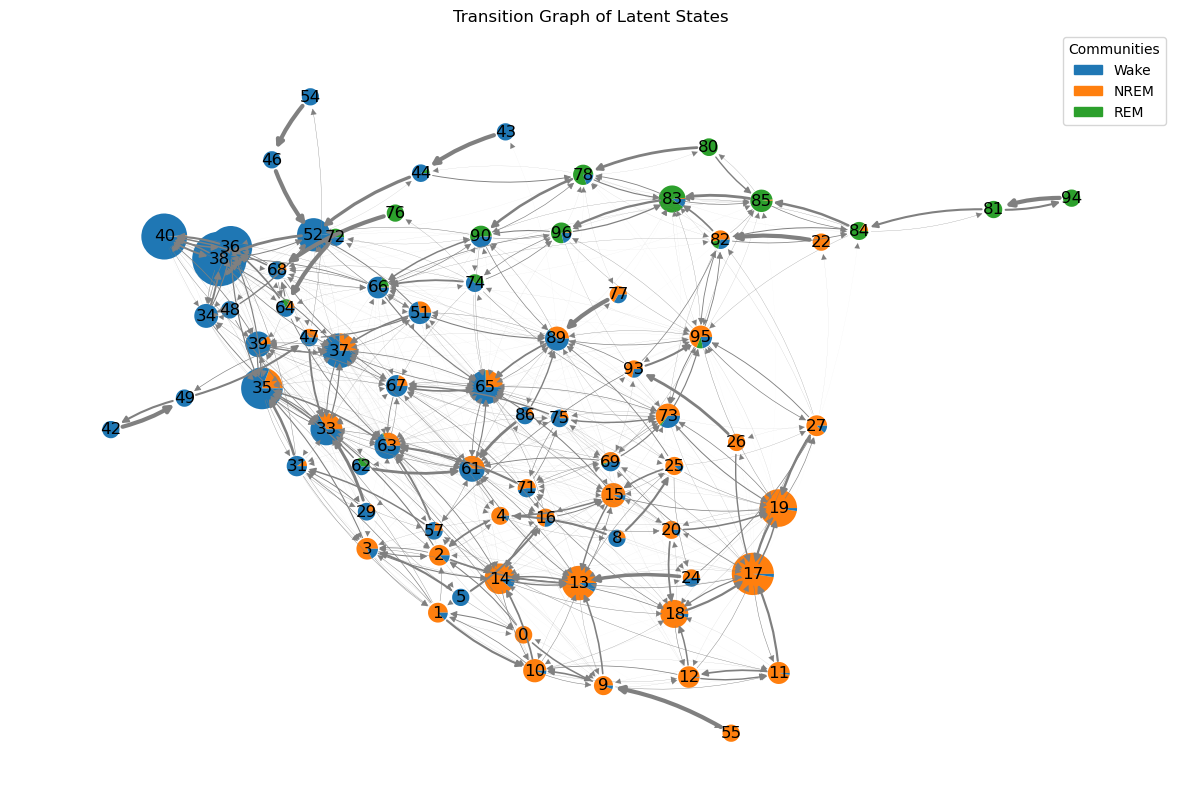

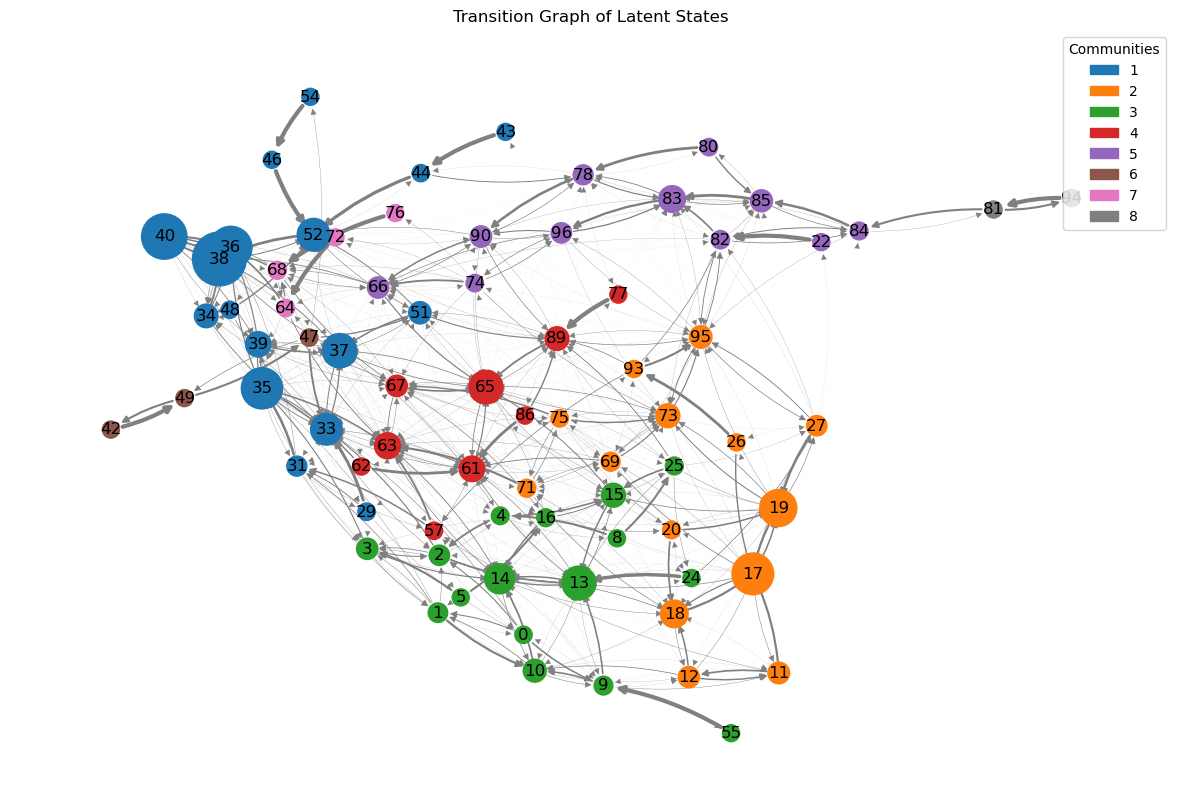

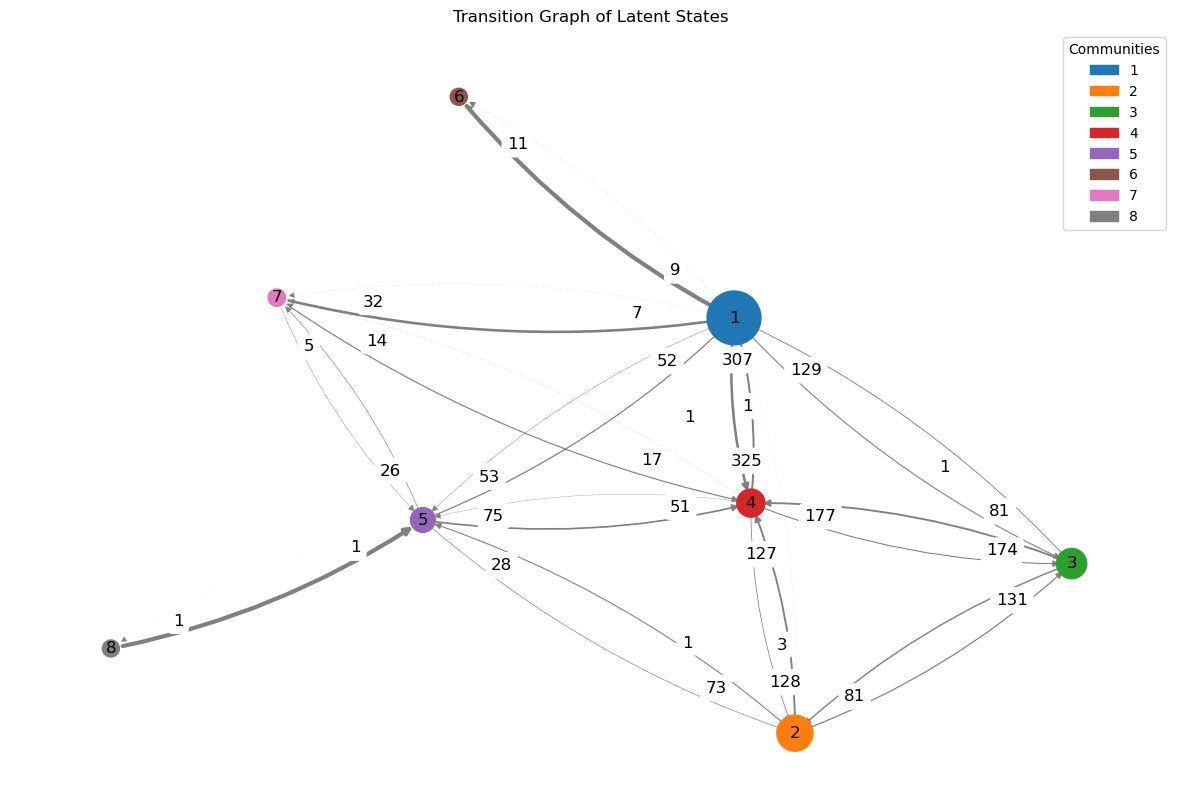

In [10]:
# Some aggregate functions to make applying the pipeline easier for quick analysis

def get_high_level_overview_for_states_file(file_name, folder_path='data', seed=None):
    """For now, I just add as much data as possible. Later on, I might improve/cut some of it"""
    df = get_df_from_states_file(file_name=file_name, folder_path=folder_path)
    #print(df.head())

    sleep_stages = simplify_states_sequence(get_states_sequence_from_df(df, 'sleep_stage'))
    stage_frequency = get_state_frequency(sleep_stages, transform_to_ratios=True)
    print('HIGH LEVEL STATS')
    for sleep_stage, ratio in stage_frequency.items():
        print(f'{sleep_stage}: {round(ratio * 100, 1)}%')
    
    draw_simplified_sleep_slab(sleep_stages, custom_title=f'Original Sleep Labels ({file_name})')
    draw_transition_graph(simplified_states_sequence=sleep_stages, draw_raw_edge_weights=True, custom_title='Original Sleep Graph', seed=seed)
    # print(build_transition_dict(sleep_stages))

    simplified_states_sequence = simplify_states_sequence(get_states_sequence_from_df(df))
    sleep_stage_mapping_frequency = get_state_sleep_stage_relationship(df)
    draw_transition_graph_with_pie_chart_nodes(simplified_states_sequence=simplified_states_sequence, 
                                               sleep_stage_mapping_frequency=sleep_stage_mapping_frequency, 
                                               seed=seed)
    
    manually_labelled_dict = get_manual_sleep_stage_mapping(df)
    # draw_transition_graph(simplified_states_sequence=simplified_states_sequence, community_mapping=manually_labelled_dict, seed=seed)


def apply_infomap_from_basic_stuff(simplified_states_sequence, sleep_stages, 
                                   sleep_stage_mapping_frequency, 
                                   use_raw_edge_weights=True, 
                                   include_self_loops=False, 
                                   node_label_mapping=None, 
                                   seed=None):
    node_community_mapping = apply_infomap(simplified_states_sequence=simplified_states_sequence, 
                                           use_raw_edge_weights=use_raw_edge_weights, 
                                           include_self_loops=include_self_loops)

    draw_all_sleep_slabs(simplified_states_sequence=simplified_states_sequence, 
                         sleep_stages=sleep_stages, 
                         node_community_mapping=node_community_mapping)
    
    draw_transition_graph_with_pie_chart_nodes(simplified_states_sequence=simplified_states_sequence, 
                                               sleep_stage_mapping_frequency=sleep_stage_mapping_frequency, 
                                               seed=seed)
    
    draw_transition_graph(simplified_states_sequence=simplified_states_sequence, 
                          community_mapping=node_community_mapping, 
                          node_label_mapping=node_label_mapping, 
                          seed=seed)
    
    draw_community_transition_graph(simplified_states_sequence, node_community_mapping, seed=seed) 


def apply_infomap_from_file(file_name, folder_path='data', use_raw_edge_weights=True, include_self_loops=False, seed=None):
    """Draw the sleep plots resulting from applying infomap on the sequence of states in the file"""
    df = get_df_from_states_file(file_name=file_name, folder_path=folder_path)
    simplified_states_sequence = simplify_states_sequence(get_states_sequence_from_df(df))
    sleep_stages = simplify_states_sequence(get_states_sequence_from_df(df, 'sleep_stage'))
    sleep_stage_mapping_frequency = get_state_sleep_stage_relationship(df)
    
    apply_infomap_from_basic_stuff(simplified_states_sequence=simplified_states_sequence, 
                                   sleep_stages=sleep_stages,
                                   sleep_stage_mapping_frequency=sleep_stage_mapping_frequency,
                                   use_raw_edge_weights=use_raw_edge_weights,
                                   include_self_loops=include_self_loops,
                                   seed=seed)

    
# get_high_level_overview_for_states_file(STATES_SEQUENCE_FILE, seed=40)

# apply_infomap_from_basic_stuff(simplified_states_sequence=simplified_states_sequence,
#                                sleep_stages=sleep_stages,
#                                sleep_stage_mapping_frequency=sleep_stage_mapping_frequency, 
#                                use_raw_edge_weights=True,
#                                include_self_loops=False,
#                                node_label_mapping=None,
#                                seed=40
#                               )

apply_infomap_from_file(STATES_SEQUENCE_FILE, use_raw_edge_weights=False, seed=40)  # "Epochs_OSBasic_Rat3_AllSDs_Artifact&TS_timeOrder.txt"  # STATES_SEQUENCE_FILE 
# TODO fix this one!

HIGH LEVEL STATS
Wake: 58.4%
NREM: 36.8%
REM: 4.8%


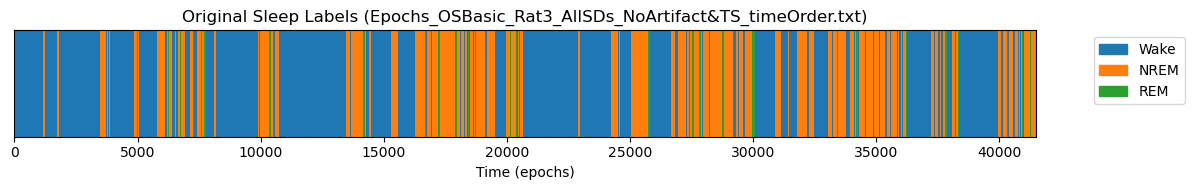

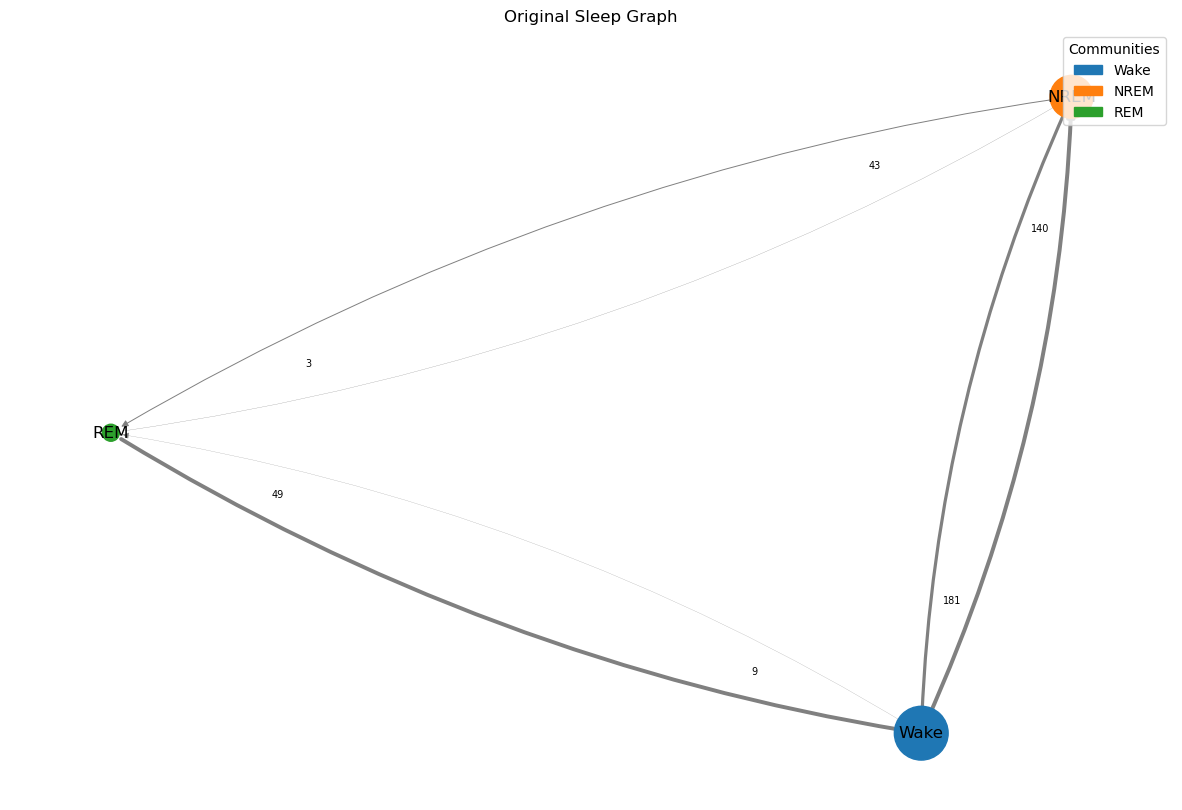

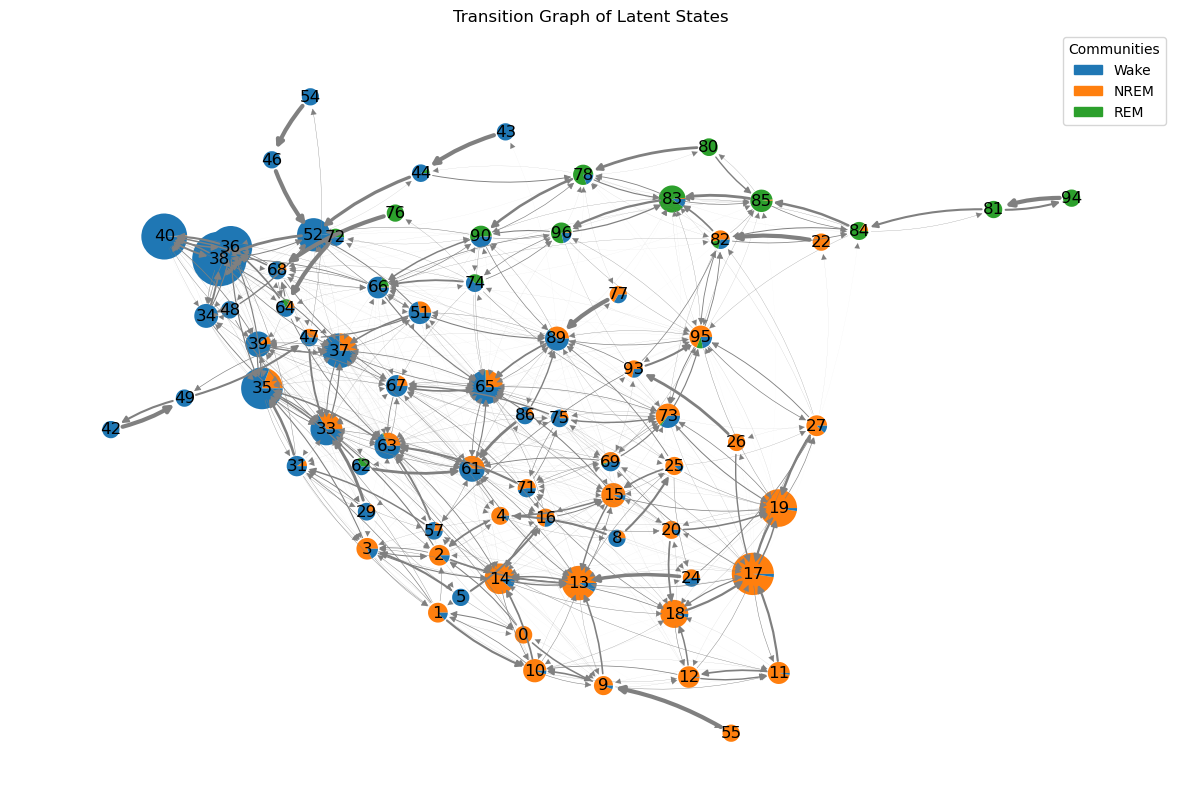

In [53]:
get_high_level_overview_for_states_file(STATES_SEQUENCE_FILE, seed=40)

In [31]:
# Here we try to deal with "special" nodes and edge. All of these functions are experimental for now

def identify_deterministic_nodes(transition_dict):
    """Return a list with nodes that transition to a single possible node"""
    deterministic_nodes = []
    for node in transition_dict:
        if len(transition_dict[node]) == 1:
            deterministic_nodes.append(node)
    return sorted(deterministic_nodes)


def merge_deterministic_nodes(simplified_states_sequence):
    """Iteratively find deterministic nodes and merge them with their sole child.
    Return a new simplified states sequence and a dictionary with the the merged nodes under each meta-node"""
    new_simplified_states_sequence = copy.deepcopy(simplified_states_sequence)
    merged_nodes_mapping = {}
    
    while deterministic_nodes := identify_deterministic_nodes(build_transition_dict(new_simplified_states_sequence)):
        for idx in range(len(new_simplified_states_sequence)-2, -1, -1):
            parent_node = new_simplified_states_sequence[idx][0]
            if parent_node in deterministic_nodes:
                child_node = new_simplified_states_sequence[idx+1][0]
                merged_nodes_mapping[child_node] = merged_nodes_mapping.get(child_node, {child_node}) | merged_nodes_mapping.get(parent_node, {parent_node})
                new_simplified_states_sequence[idx] = new_simplified_states_sequence[idx+1]
        new_simplified_states_sequence = resimplify_simplified_states_sequence(new_simplified_states_sequence)  
            
    return new_simplified_states_sequence, merged_nodes_mapping

# TODO fix/finish this function!
def apply_infomap_after_merging_deterministic_nodes(simplified_states_sequence, sleep_stages, manually_labelled_dict=None, use_raw_edge_weights=True, seed=None):
    """Do take these results with a grain of salt as merging sometimes adds nodes to the wrong communities (e.g., NREM instead of REM)"""
    merged_simplified_states_sequence, node_label_mapping = merge_deterministic_nodes(simplified_states_sequence)
    clean_node_label_mapping = {meta_node: '_'.join(str(x) for x in nodes) for meta_node, nodes in node_label_mapping.items()}
    apply_infomap_from_basic_stuff(simplified_states_sequence=merged_simplified_states_sequence,
                                   sleep_stages=sleep_stages,
                                   manually_labelled_dict=manually_labelled_dict,
                                   use_raw_edge_weights=use_raw_edge_weights,
                                   node_label_mapping=clean_node_label_mapping,
                                   seed=seed)

merged_simplified_states_sequence, node_label_mapping = merge_deterministic_nodes(simplified_states_sequence)